In [4]:
import os
import ee
import datetime
import time
import sklearn

import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from dateutil.relativedelta import relativedelta
from sklearn import preprocessing

ee.Initialize()

In [100]:
data = {}
# https://developers.google.com/earth-engine/datasets/catalog/NASA_GLDAS_V020_NOAH_G025_T3H
data['gldas'] = [ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H'), 'Evap_tavg', 730] # 86400*30

# https://developers.google.com/earth-engine/datasets/catalog/NASA_NLDAS_FORA0125_H002
data['nldas'] = [ee.ImageCollection('NASA/NLDAS/FORA0125_H002'), 'potential_evaporation', 1]

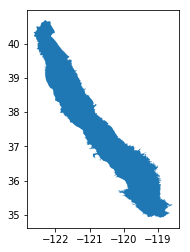

In [101]:
'''
Set the init params:
1) Area: Read from Shapefile
2) Years to analyze: Supplied
3) Scale (optional): Resolution at which to perform analysis
4) Satellites / datasets: Queried from Earth Engine
'''

##### AREA #####

# HUC 4s draining to the CV 
cv = gp.read_file("../shape/cv.shp")
cv2 = cv.geometry.simplify(0.1)
lls = cv2.geometry.iloc[0]
x,y = lls.exterior.coords.xy
coords = [list(zip(x,y))]
area = ee.Geometry.Polygon(coords)
sa_km3 = round(cv2.area[0] * 10000, 2)
        
##### TIME RANGE #####
years = [x for x in range(2001, 2018)]
months = range(1,13)

##### SCALE #####
cv.plot()

In [102]:
years = range(2001, 2019)
months = range(1,13)
start = datetime.datetime(years[0], 1, 1)
end = datetime.datetime(years[-1]+1, 1, 1)
dt_idx = pd.date_range(start,end, freq='M')

In [103]:

def gen_polys(geometry, dx=0.25, dy=0.25):
    
    '''
    Return ee.ImaceCollection of polygons used to submit full res queries
    '''
    
    bounds = ee.Geometry(geometry).bounds()
    coords = ee.List(bounds.coordinates().get(0))
    ll = ee.List(coords.get(0))
    ur = ee.List(coords.get(2))
    xmin = ll.get(0)
    xmax = ur.get(0)
    ymin = ll.get(1)
    ymax = ur.get(1)

    latlist = ee.List.sequence(ymin, ymax, dx)
    lonlist = ee.List.sequence(xmin, xmax, dy)
    
    polys = []
    
    for lon in lonlist.getInfo():
        for lat in latlist.getInfo():
        
            def make_rect(lat, lon):
                lattemp = ee.Number(lat)
                lontemp = ee.Number(lon)
                uplattemp = lattemp.add(dy)
                lowlontemp = lontemp.add(dx)

                return ee.Feature(ee.Geometry.Polygon([[lontemp, lattemp],[lowlontemp, lattemp],[lowlontemp, uplattemp],[lontemp, uplattemp]]))
            
            poly = make_rect(lat,lon)
            polys.append(poly)
    
    return ee.FeatureCollection(ee.List(polys))

def chunk(dataset,area):
    polys = gen_polys(area)
    d = polys.getInfo()
    results = []
    for i in d['features']:
        aoi = ee.Geometry.Polygon(i['geometry']['coordinates']).intersection(area)
        t = col.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(month, month, 'month')).select(var).filterBounds(aoi).sum()
        t2 = t.multiply(1e-3).multiply(ee.Image.pixelArea()).multiply(scaling_factor).multiply(1e-9)

        scale = t2.projection().nominalScale()
        sumdict  = t2.reduceRegion(
            reducer = ee.Reducer.sum(),
            geometry = aoi,
            scale = scale)

        result = sumdict.getInfo()[var]
        results.append(result)
        print('poly complete')
        
    return results



In [104]:
col = data['gldas'][0]
var = data['gldas'][1]
var_name = data['gldas'][1]
scaling_factor = data['gldas'][2]

In [107]:
def calc_monthly_sum(ImageCollection, var, startdate, enddate):
    
    '''
    Calculates monthly sum for hourly data. works for GLDAS / NLDAS 
    '''
    
    start = startdate.strftime("%Y-%m-%d")
    num_steps = len(pd.date_range(startdate,enddate, freq='M'))
    
    sums = []
    seq = ee.List.sequence(0, num_steps)
    
    for i in seq.getInfo():
        print(i)
        start = ee.Date(start).advance(i, 'month')
        end = start.advance(1, 'month');
        im = ee.ImageCollection(ImageCollection).select(var).filterDate(start, end).sum().set('system:time_start', start.millis())
        ic = im.multiply(im.pixelArea()).multiply(scaling_factor).multiply(1e-9).multiply(1e-3)
        scale = ic.projection().nominalScale()
        
        sumdict  = ic.reduceRegion(
            reducer = ee.Reducer.sum(),
            geometry = area,
            scale = scale)
        total = sumdict.getInfo()[var]
        print(total)
        sums.append(total)

    return sums

In [108]:
t = calc_monthly_sum(data['gldas'][0],data['gldas'][1], start, end)

0.0
0.05905001844018667
1.0
0.09132444739094564
2.0
0.25926479438912176
3.0
0.10246545623794448
4.0
0.04890089860627191
5.0
0.24406886871248798
6.0
0.010805943125799737
7.0
0.32709785596655666
8.0
0.06637682135702848
9.0
0.047318319835606325
10.0
0.10127117154733854
11.0
0.19966363382306118
12.0
0.07686646612061093
13.0
0.04153932208930852
14.0
0.0698231524930748
15.0
0.07392044434923907
16.0
0.26245223321935696
17.0
0.03253435973104225
18.0
0.24777454215346137
19.0
0.04995539613918592
20.0
0.12100784656727266
21.0


EEException: Image.multiply: If one image has no bands, the other must also have no bands. Got 0 and 1.

In [72]:
t.getInfo()

{'type': 'Image',
 'bands': [{'id': 'Albedo_inst',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'crs': 'EPSG:4326',
   'crs_transform': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
  {'id': 'AvgSurfT_inst',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'crs': 'EPSG:4326',
   'crs_transform': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
  {'id': 'CanopInt_inst',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'crs': 'EPSG:4326',
   'crs_transform': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
  {'id': 'ECanop_tavg',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'crs': 'EPSG:4326',
   'crs_transform': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
  {'id': 'ESoil_tavg',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'crs': 'EPSG:4326',
   'crs_transform': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
  {'id': 'Evap_tavg',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'crs': 'EPSG:4326',
   'crs_transform': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]},


In [ ]:

t2 = t.multiply(1e-3).multiply(ee.Image.pixelArea()).multiply(scaling_factor).multiply(1e-9)
# convert mm to m, multiply by pixel area (m^2), multiply by scaling factor, m^3 to km^3
scale = t2.projection().nominalScale()
sumdict  = t2.reduceRegion(
    reducer = ee.Reducer.sum(),
    geometry = area,
    scale = scale)

result = sumdict.getInfo()[var]